# Teamwork: Planning a stock report

> **From now on, we will not execute the code in the Jupyter notebook, this is because of two reasons:**
> 1. We are going to ask our agents to write code and execute it for us. Executing code by an agent inside a Jupyter notebook can be tricky and requires additional configuration. It also depends of the OS being used. To avoid dealing with these issues, we will simply move on to executing scripts instead of notebooks
> 2. We are going to start preparing our code to be able to deploy it on the cloud later, so that we can share a link towards our Agents based app. It is not possible to deploy notebooks, so we are going to start using scripts to get ready for that.
> We are still going to use notebooks to describe and explain our code, but do not execute the code here, instead use the script version of this code.

For this exercise, we are going to setup a team of agents and let them determine how to accomplish the task by themsleves. This is a less efficient method than the ones we've previously used, but it's the one that requires the least of involvement on the user's part.

In order for the team to be able to work together, we will provide them with a Planner. The Planner agent's role will be to determine which task should be done first and which agent should accomplish it. This means that we should something to the agent's definitions to let other agents know about their role, so that the Planner can determine which agent can do which task.

The task we are going to focus on will be writing a blogpost about the stock performance of a specific asset.

In [ ]:
# We'll always have to start by creating a llm_config object to configure our agents
llm_config = {
    "model": "gpt-4o", 
    "api_key": "sk-proj-GjIUEqAKI2j04dlC18rZT3BlbkFJnLTC5AeosFLwmSAxKzNU"
    }

## Team description

* **User_proxy or Admin**: to allow the user to comment on the report and ask the writer to refine it.
* **Planner**: to determine relevant information needed to complete the task.
* **Engineer**: to write code using the defined plan by the planner.
* **Executor**: to execute the code written by the engineer.
* **Writer**: to write the report.

## The task

In [ ]:
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-07-26."

## Defining our agents

### User proxy

This agent will allow us to interact with the agents, it can use auto-reply, so it will have access to an LLM config, but it will also have its Human Input Mode to Always, which will allow us to interact with the agents.

In [ ]:
import autogen

user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config, 
    human_input_mode="ALWAYS", # If user does not provide feedback, the LLM will do it for us
)

### Planner Agent

#### Description message

Until now, our agents had a **system message prompt**, this message is only known to each agent and defines how they should behave.  
We are now going to add a **description message**, this message this time is known by other agents to understand this agent's role. This way, other agents, and specifically the Planner, can determine which agent can accomplish which task.

Let's define a Planner with a description.

In [ ]:
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

### Engineer Agent

The Engineer agent already has a default system prompt, which is enough for the task we would like it to accomplish, write code.  
We are going to add a description message that lets other agents know about its role. Other agents will also know about the name of agents, and in somes cases that might be enough to define their roles.

In [ ]:
# system msg: Already has a default one because it is a code writer
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

# Check engineer system prompt message
print(engineer.system_message)

### Executor Agent

The Executor agent is a code executor similar to the ones we already used. Since this time there will be several agents exchanging through a group chat and we're unsure in which order that'll happen, we are going to add an argument in the `code_execution_config`, a parameter that specifies that we want this agent to know about the last 3 messages instead of the last one only.

The name of the agent in this case is enough to share its role with other agents.

In [ ]:
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

### Writer Agent

This agent is the writer agent who is going to write the report we want as a blogpost. This agent will have a system message and a description.

In [ ]:
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

## The group chat

We are now going to define the chat, this time, it's going to be a Group Chat. This means we won't define ay conversation order other than specifying who is the Manager. We'll just list the agents who'll be taken part in this group chat, and the max number of turns  we allow for it to last:

In [ ]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[], # No initial message
    max_round=20,
)

### Group Chat Manager

We will now provide this group chat with a Manager.

In [ ]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, 
    llm_config=llm_config
)

### Chat initiation

Let's now initiate the chat with a message from the User Proxy agent, us, to the manager, giving the the task we previously defined:

In [ ]:
groupchat_result = user_proxy.initiate_chat(
    manager, # We initiate between user and manager so we can give the task
    message=task,
)

And execute the script wiht this code! This is pretty cool to watch happen actually, you will see your agents interact without help from you to accomplish the task. The planner should determine which task should be done in whcih order and dispatch preparations and execution to the Engieer and Code Executor and then to the Writer to accomplish the task specified. 

For my first run, the agents produced the blogpost below and even produced a chart for it:

# Nvidia's Stock Price Performance in the Past Month

As of June 28, 2024, Nvidia (NASDAQ: NVDA) has shown notable performance in the stock market. In this blog post, we'll take a close look at Nvidia's stock price movements over the past month, highlight key statistics, and analyze the factors that could have influenced its performance.

## Key Statistics

Over the past month, Nvidia's stock displayed the following key metrics:

* **Average Closing Price** : $122.79

* **Highest Closing Price** : $135.58

* **Lowest Closing Price** : $109.62

* **Percentage Change** : 7.99%

These statistics underline Nvidia's robust market presence, showcasing both growth potential and stability.

## Stock Price Trend

Below is a visual representation of Nvidia's stock price over the past month:

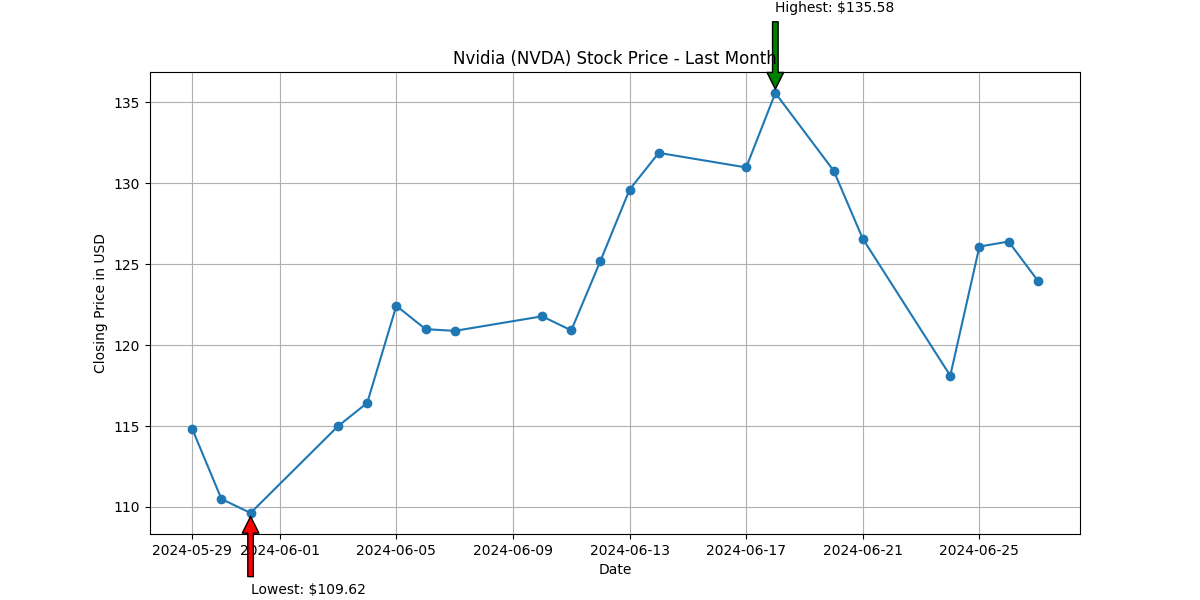

As seen in the chart, Nvidia's stock experienced several fluctuations, with key highlights being:

- **Highest Closes**: The highest closing price of $135.58 was observed towards mid-June.

- **Lowest Closes**: The lowest closing price was $109.62 at the end of May.

### Analysis of Movements

1. **End of May Drop**:
   - The low closing price at the end of May reflects a dip which could be attributed to market-wide fluctuations or sector-specific events.

2. **Mid-June Peak**:
   - The peak observed in mid-June could be linked to positive quarterly earnings reports, announcements of new product lines, or significant partnerships in the tech industry.

## Market Context

Nvidia has been a leading player in the graphics processing industry, especially with the rise of artificial intelligence, gaming, and data center applications. Over the past month, several developments might have influenced its stock performance: 

- **AI Advancements**: Nvidia's continuous innovations and advancements in AI might have driven investor confidence.        
- **Tech Sector Dynamics**: Movements within the broader tech sector, including competitor performance and market sentiment.

## Conclusion

Overall, Nvidia has demonstrated substantial growth over the past month, reinforcing its position as a strong performer in the stock market. The detailed statistics and chart tell a story of resilience and potential for future growth.

For investors and market watchers, Nvidia remains a crucial stock to monitor, given its pivotal role in technology advancements and market dynamics.

_Disclaimer: This analysis is for informational purposes only and should not be construed as financial advice. Always conduct your own research or consult with a professional advisor before making investment decisions._

---

# Group Chat with constraints

In some cases, you might want to constraint exchanges within the chat. That measn that you might want to stop some agents from immediately interacting with other agents or the opposite. You can do so by adding an argument to your Group Chat definition.

For example, if we want to ensure that the engineer will only interact with the **Executor** or **User proxy** (us), we can specify that.  
Here is how we would define such constraints:

In [ ]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=20,
    allowed_or_disallowed_speaker_transitions={
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

We can then simply re-start the chat with these constraints:

In [ ]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)